
# Install Dependencies



In [ ]:
# Install Dependencies
!pip install transformers datasets accelerate sentencepiece "bitsandbytes>=0.40.0" peft huggingface_hub
!python -m bitsandbytes


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 15.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 14.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.
++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++
++++++++++++++++++ BU

# Load and Prepare the Datasets

In [ ]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 21.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 16.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 17.5 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
import torch
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    TrainingArguments,
    Trainer,
    DataCollatorForLanguageModeling,
    BitsAndBytesConfig,
)
from datasets import load_dataset
from peft import LoraConfig, get_peft_model
import os

# Load Datasets
pubmedqa = load_dataset('pubmed_qa', 'pqa_labeled')
medqa = load_dataset("bigbio/med_qa", trust_remote_code=True)
medmcqa = load_dataset("medmcqa")

from sklearn.model_selection import train_test_split

def create_pubmedqa_split(test_size=0.2, random_state=42):
    pubmedqa_data = load_dataset('pubmed_qa', 'pqa_labeled')
    train_data = pubmedqa_data['train']

    # Convert to list for splitting
    data_dict = {
        'question': train_data['question'],
        'context': train_data['context'],
        'final_decision': train_data['final_decision'],
        'pubid': train_data['pubid']
    }

    # Create indices for splitting
    indices = list(range(len(train_data)))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=random_state)

    # Split the data
    train_split = {k: [v[i] for i in train_idx] for k, v in data_dict.items()}
    test_split = {k: [v[i] for i in test_idx] for k, v in data_dict.items()}

    return train_split, test_split

# Create custom splits for PubMedQA
train_data, test_data = create_pubmedqa_split()

# Print some information about the datasets
print(f"Train set size: {len(train_data['question'])}")
print(f"Test set size: {len(test_data['question'])}")
print("\nPubMedQA sizes:")
print(f"Original train: {len(pubmedqa['train'])} samples")
print("Custom Splits:")
print(f"Custom train: {len(train_data['question'])} samples")
print(f"Custom test: {len(test_data['question'])} samples")

print("\nMedQA sizes:")
print(f"Train: {len(medqa['train'])} samples")
print(f"Test: {len(medqa['test'])} samples")
print(f"Validation: {len(medqa['validation'])} samples")

print("\nMedMCQA sizes:")
print(f"Train: {len(medmcqa['train'])} samples")
print(f"Test: {len(medmcqa['test'])} samples")
print(f"Validation: {len(medmcqa['validation'])} samples")

print("\nPubMedQA Head:")
print(pubmedqa['train'].to_pandas().head())

print("\nMedQA Head:")
print(medqa['train'].to_pandas().head())

print("\nMedMCQA Head:")
print(medmcqa['train'].to_pandas().head())


README.md:   0%|          | 0.00/5.19k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.08M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1000 [00:00<?, ? examples/s]

README.md:   0%|          | 0.00/1.44k [00:00<?, ?B/s]

med_qa.py:   0%|          | 0.00/11.1k [00:00<?, ?B/s]

bigbiohub.py:   0%|          | 0.00/19.3k [00:00<?, ?B/s]

data_clean.zip:   0%|          | 0.00/132M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/454fe0fdcb22e71e2762c35bcbe1c9a23f7b0154ade8598b60ee0dc6db7d537a/data_clean/questions/US/train.jsonl


Generating test split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/454fe0fdcb22e71e2762c35bcbe1c9a23f7b0154ade8598b60ee0dc6db7d537a/data_clean/questions/US/test.jsonl


Generating validation split: 0 examples [00:00, ? examples/s]

/root/.cache/huggingface/datasets/downloads/extracted/454fe0fdcb22e71e2762c35bcbe1c9a23f7b0154ade8598b60ee0dc6db7d537a/data_clean/questions/US/dev.jsonl


README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

Train set size: 800
Test set size: 200

PubMedQA sizes:
Original train: 1000 samples
Custom Splits:
Custom train: 800 samples
Custom test: 200 samples

MedQA sizes:
Train: 10178 samples
Test: 1273 samples
Validation: 1272 samples

MedMCQA sizes:
Train: 182822 samples
Test: 6150 samples
Validation: 4183 samples

PubMedQA Head:
      pubid                                           question  \
0  21645374  Do mitochondria play a role in remodelling lac...   
1  16418930  Landolt C and snellen e acuity: differences in...   
2   9488747  Syncope during bathing in infants, a pediatric...   
3  17208539  Are the long-term results of the transanal pul...   
4  10808977  Can tailored interventions increase mammograph...   

                                             context  \
0  {'contexts': ['Programmed cell death (PCD) is ...   
1  {'contexts': ['Assessment of visual acuity dep...   
2  {'contexts': ['Apparent life-threatening event...   
3  {'contexts': ['The transanal endorectal pull-t..

# Evaluation Functions



In [ ]:
import torch
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
import re

def plot_confusion_matrix(cm, labels, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

def evaluate_dataset(predictions, true_labels, dataset_name):
    accuracy = accuracy_score(true_labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')
    labels = sorted(list(set(true_labels)))
    cm = confusion_matrix(true_labels, predictions, labels=labels)
    plot_confusion_matrix(cm, labels, f'{dataset_name} Confusion Matrix')

    print(f"\n{dataset_name} Results:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")


# PubMedQA Evaluation

In [ ]:
def evaluate_pubmedqa(train_data, test_data):
    predictions = []
    true_labels = []

    for sample in test_data['question']:
        idx = test_data['question'].index(sample)
        question = sample
        context = ' '.join(test_data['context'][idx]['contexts'])
        true_label = test_data['final_decision'][idx]

        prompt = f"Context: {context}\nQuestion: {question}\nAnswer (yes/no/maybe):"
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=1)

        predicted = tokenizer.decode(outputs[0][-1:], skip_special_tokens=True).strip().lower()
        predictions.append(predicted)
        true_labels.append(true_label)

    evaluate_dataset(predictions, true_labels, "PubMedQA")


# MedQA Evaluation

In [ ]:
def extract_first_digit(text):
    """Extract the first single digit from the text."""
    matches = re.findall(r'\b[1-9]\b', text)
    return int(matches[0]) if matches else None

# def evaluate_medqa(num_tests=None):
#     predictions = []
#     true_labels = []
#     test_data_list = list(medqa['test'])

#     if num_tests is not None:
#         if num_tests > len(test_data_list):
#             print(f"Requested {num_tests} tests, only {len(test_data_list)} available. Using all available tests.")
#             num_tests = len(test_data_list)
#         test_data_list = test_data_list[:num_tests]
#         print(f"Evaluating on {num_tests} test samples.")
#     else:
#         print(f"Evaluating on all {len(test_data_list)} test samples.")

#     for sample in tqdm(test_data_list, desc="Evaluating MedQA"):
#         question = sample['question']
#         options = [opt['value'] for opt in sample['options']]
#         true_answer = sample['answer']

#         prompt = f"Question: {question}\n\nOptions:\n"
#         for i, opt in enumerate(options, 1):
#             prompt += f"{i}. {opt}\n"
#         prompt += "\nProvide only the number (1-4) of the correct answer: "

#         inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

#         with torch.no_grad():
#             outputs = model.generate(
#                 **inputs,
#                 max_new_tokens=2,
#                 num_beams=1,
#                 do_sample=False
#             )

#         predicted = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
#         predicted_digit = extract_first_digit(predicted)

#         if predicted_digit is not None and 1 <= predicted_digit <= len(options):
#             predicted_answer = options[predicted_digit - 1]
#         else:
#             predicted_answer = options[0]

#         predictions.append(predicted_answer)
#         true_labels.append(true_answer)

#     # Calculate metrics
#     accuracy = accuracy_score(true_labels, predictions)
#     precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

#     print(f"\nMedQA Evaluation Results:")
#     print(f"Number of Test Samples: {len(test_data_list)}")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")

def evaluate_medqa(num_tests=None):
    """
    Evaluate the MedQA model on a subset of the test dataset and produce confusion matrix.
    """
    predictions = []
    true_labels = []

    test_data_list = list(medqa['test'])

    if num_tests is not None:
        if num_tests > len(test_data_list):
            print(f"Requested {num_tests} tests, only {len(test_data_list)} available. Using all available tests.")
            num_tests = len(test_data_list)
        test_data_list = test_data_list[:num_tests]
        print(f"Evaluating on {num_tests} test samples.")
    else:
        print(f"Evaluating on all {len(test_data_list)} test samples.")

    for sample in tqdm(test_data_list, desc="Evaluating MedQA"):
        question = sample['question']
        options = [opt['value'] for opt in sample['options']]
        true_answer = sample['answer']

        prompt = f"Question: {question}\n\nOptions:\n"
        for i, opt in enumerate(options, 1):
            prompt += f"{i}. {opt}\n"
        prompt += "\nProvide only the number (1-4) of the correct answer: "

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=2,
                num_beams=1,
                do_sample=False
            )

        predicted = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        predicted_digit = extract_first_digit(predicted)

        if predicted_digit is not None and 1 <= predicted_digit <= len(options):
            predicted_answer = options[predicted_digit - 1]
        else:
            predicted_answer = options[0]

        predictions.append(predicted_answer)
        true_labels.append(true_answer)

    print("\nMedQA Evaluation Results:")
    print(f"Number of Test Samples: {len(test_data_list)}")

    # Evaluate and produce confusion matrix
    evaluate_dataset(predictions, true_labels, "MedQA")




# MedMCQA Evaluation

In [ ]:
# def evaluate_medmcqa(sample_size=None):
#     # Evaluate model on MedMCQA validation set.
#     from sklearn.metrics import precision_recall_fscore_support, accuracy_score
#     from tqdm import tqdm

#     dataset = load_dataset("openlifescienceai/medmcqa")
#     predictions = []
#     true_labels = []

#     validation_data = list(dataset['validation'])
#     if sample_size:
#         validation_data = validation_data[:sample_size]

#     for sample in tqdm(validation_data, desc="Evaluating MedMCQA"):
#         question = sample['question']
#         options = [sample['opa'], sample['opb'], sample['opc'], sample['opd']]
#         true_answer = options[int(sample['cop']) - 1]

#         prompt = f"""Question: {question}\n\nOptions:\n"""
#         for i, opt in enumerate(options, 1):
#             prompt += f"{i}. {opt}\n"
#         prompt += "\nProvide only the number (1-4) of the correct answer: "

#         inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

#         with torch.no_grad():
#             outputs = model.generate(
#                 **inputs,
#                 max_new_tokens=2,
#                 num_beams=1,
#                 do_sample=False
#             )

#         predicted = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
#         predicted_digit = extract_first_digit(predicted)

#         if predicted_digit is not None and 1 <= predicted_digit <= 4:
#             predicted_answer = options[predicted_digit - 1]
#         else:
#             predicted_answer = options[0]

#         predictions.append(predicted_answer)
#         true_labels.append(true_answer)

#     accuracy = accuracy_score(true_labels, predictions)
#     precision, recall, f1, _ = precision_recall_fscore_support(true_labels, predictions, average='weighted')

#     print(f"\nMedMCQA Validation Results ({len(validation_data)} samples):")
#     print(f"Accuracy: {accuracy:.4f}")
#     print(f"Precision: {precision:.4f}")
#     print(f"Recall: {recall:.4f}")
#     print(f"F1 Score: {f1:.4f}")

#     return predictions, true_labels


def evaluate_medmcqa(sample_size=None):
    """
    Evaluate model on MedMCQA validation set and produce confusion matrix.
    """
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    from tqdm import tqdm
    dataset = load_dataset("openlifescienceai/medmcqa")

    predictions = []
    true_labels = []

    validation_data = list(dataset['validation'])
    if sample_size:
        validation_data = validation_data[:sample_size]

    for sample in tqdm(validation_data, desc="Evaluating MedMCQA"):
        question = sample['question']
        options = [sample['opa'], sample['opb'], sample['opc'], sample['opd']]
        true_answer = options[int(sample['cop']) - 1]

        prompt = f"""Question: {question}\n\nOptions:\n"""
        for i, opt in enumerate(options, 1):
            prompt += f"{i}. {opt}\n"
        prompt += "\nProvide only the number (1-4) of the correct answer: "

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=2,
                num_beams=1,
                do_sample=False
            )

        predicted = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        predicted_digit = extract_first_digit(predicted)

        if predicted_digit is not None and 1 <= predicted_digit <= 4:
            predicted_answer = options[predicted_digit - 1]
        else:
            predicted_answer = options[0]

        predictions.append(predicted_answer)
        true_labels.append(true_answer)

    print(f"\nMedMCQA Validation Results ({len(validation_data)} samples):")
    # Evaluate and produce confusion matrix
    evaluate_dataset(predictions, true_labels, "MedMCQA")





# Simple Baselines (Majority Class)

PubMedQA Majority Class Baseline:
Training set evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


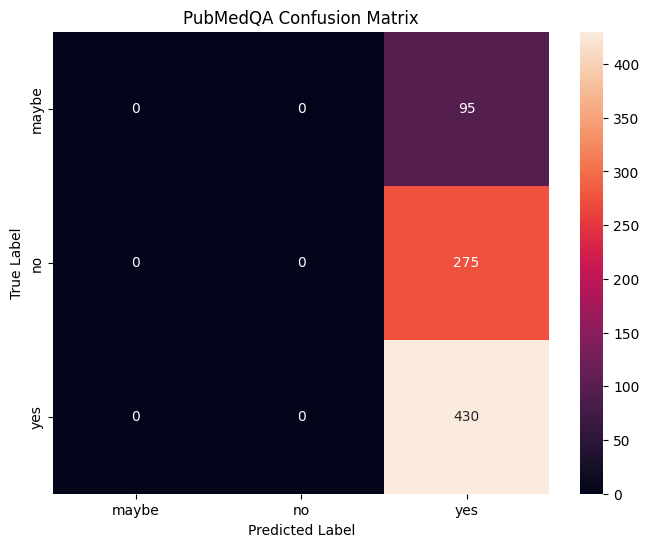


PubMedQA Results:
Accuracy: 0.5375
Precision: 0.2889
Recall: 0.5375
F1 Score: 0.3758
Validation set evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


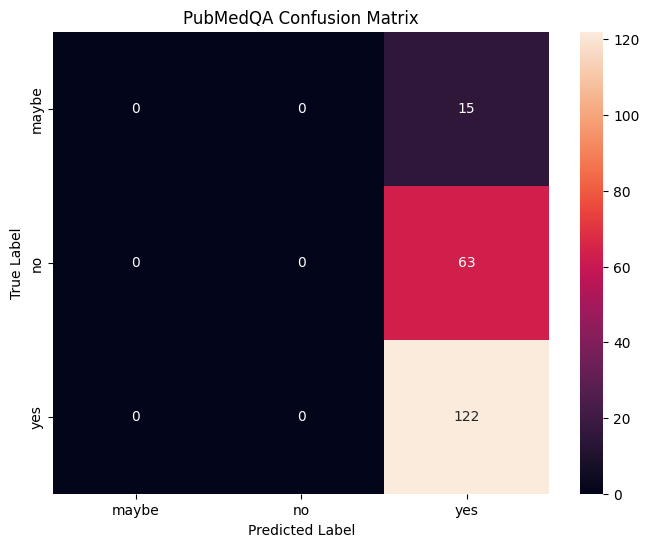


PubMedQA Results:
Accuracy: 0.6100
Precision: 0.3721
Recall: 0.6100
F1 Score: 0.4622

MedQA Majority Class Baseline:
Training set evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


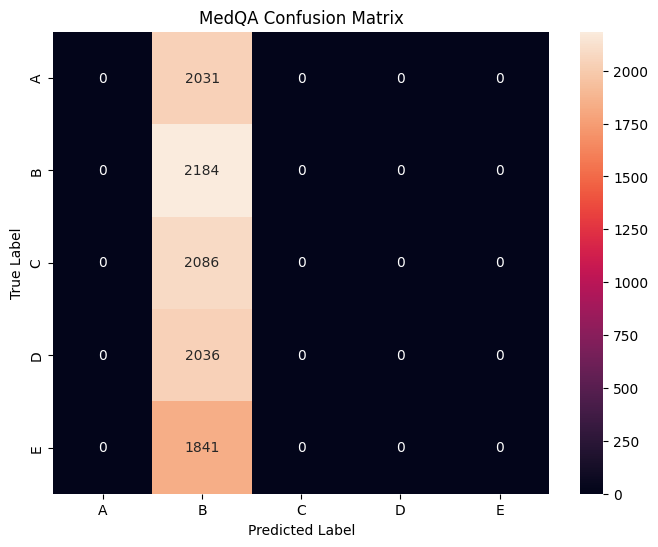


MedQA Results:
Accuracy: 0.2146
Precision: 0.0460
Recall: 0.2146
F1 Score: 0.0758
Validation set evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


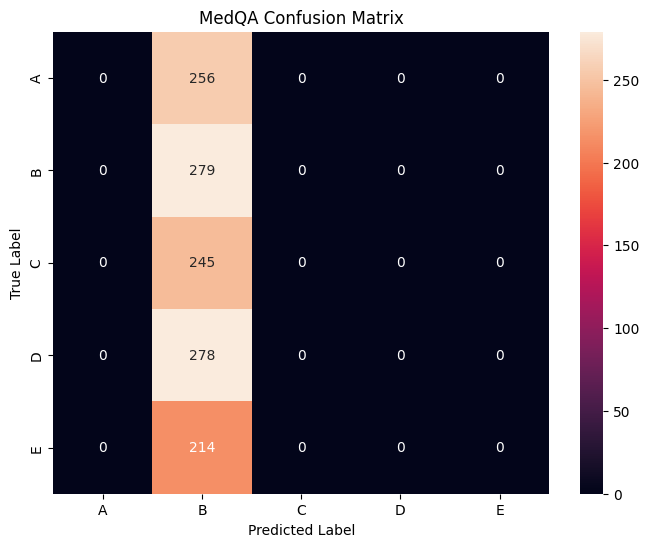


MedQA Results:
Accuracy: 0.2193
Precision: 0.0481
Recall: 0.2193
F1 Score: 0.0789

MedMCQA Majority Class Baseline:
Training set evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


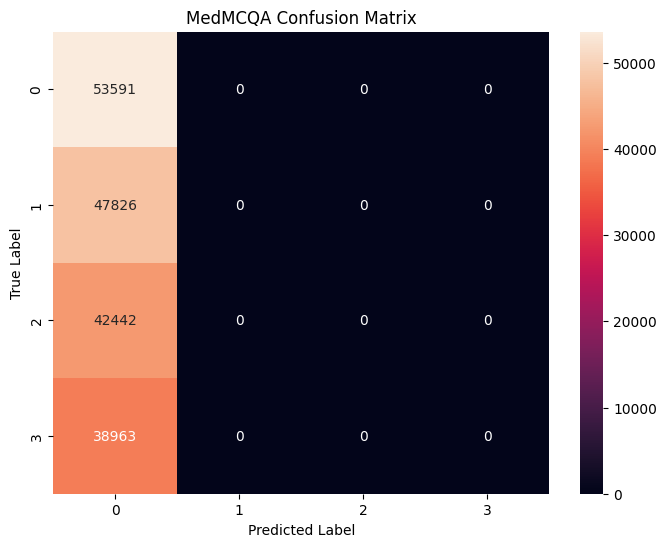


MedMCQA Results:
Accuracy: 0.2931
Precision: 0.0859
Recall: 0.2931
F1 Score: 0.1329
Validation set evaluation:


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


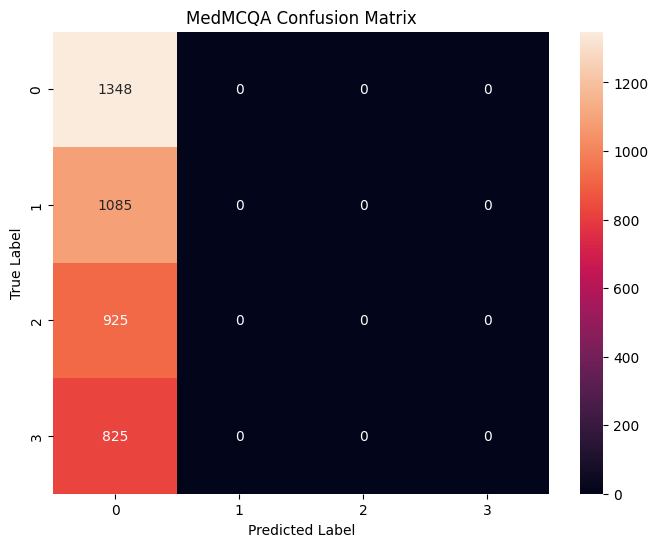


MedMCQA Results:
Accuracy: 0.3223
Precision: 0.1038
Recall: 0.3223
F1 Score: 0.1571


In [ ]:
# PubMedQA Majority Class Baseline
pubmedqa = load_dataset('pubmed_qa', 'pqa_labeled')
df = pubmedqa['train'].to_pandas()

train_df, val_df = train_test_split(df, test_size=0.2, random_state=42)
majority_class = train_df['final_decision'].mode()[0]

val_preds = [majority_class] * len(val_df)
train_preds = [majority_class] * len(train_df)

print("PubMedQA Majority Class Baseline:")
print("Training set evaluation:")
evaluate_dataset(train_preds, train_df['final_decision'], "PubMedQA")
print("Validation set evaluation:")
evaluate_dataset(val_preds, val_df['final_decision'], "PubMedQA")

# MedQA Majority Class Baseline
medqa = load_dataset("bigbio/med_qa")
val_df = medqa['validation'].to_pandas()
train_df = medqa['train'].to_pandas()
majority_class = train_df['answer_idx'].mode()[0]

val_preds = [majority_class] * len(val_df)
train_preds = [majority_class] * len(train_df)

print("\nMedQA Majority Class Baseline:")
print("Training set evaluation:")
evaluate_dataset(train_preds, train_df['answer_idx'], "MedQA")
print("Validation set evaluation:")
evaluate_dataset(val_preds, val_df['answer_idx'], "MedQA")

# MedMCQA Majority Class Baseline
medmcqa = load_dataset("medmcqa")
val_df = medmcqa['validation'].to_pandas()
train_df = medmcqa['train'].to_pandas()
majority_class = train_df['cop'].mode()[0]

val_preds = [majority_class] * len(val_df)
train_preds = [majority_class] * len(train_df)

print("\nMedMCQA Majority Class Baseline:")
print("Training set evaluation:")
evaluate_dataset(train_preds, train_df['cop'], "MedMCQA")
print("Validation set evaluation:")
evaluate_dataset(val_preds, val_df['cop'], "MedMCQA")


# Load and Evaluate Llama-2-7b-hf Model (Base)

In [ ]:
from huggingface_hub import login
login("**********************)

model_name = "meta-llama/Llama-2-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, token=True)
model = AutoModelForCausalLM.from_pretrained(model_name, token=True)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

# Distribute model if multiple GPUs
if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)




tokenizer_config.json:   0%|          | 0.00/776 [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/609 [00:00<?, ?B/s]

model.safetensors.index.json:   0%|          | 0.00/26.8k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.98G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/3.50G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

# Evaluation for Llama-2-7b-hf on PubMedQA, MedQA, MedMCQA

In [ ]:
# Evaluate PubMedQA with Llama-2-7b-hf
evaluate_pubmedqa(train_data, test_data)

In [ ]:
# Run MedQA evaluation
evaluate_medqa()

In [ ]:
# Run MedMCQA evaluation
evaluate_medmcqa()


# Install Unsloth and Additional Dependencies

In [ ]:
!pip install unsloth
!pip uninstall unsloth -y
!pip install --upgrade --no-cache-dir --no-deps git+https://github.com/unslothai/unsloth.git
!pip install --no-deps packaging ninja einops flash-attn xformers trl peft accelerate bitsandbytes


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.2/59.2 kB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 174.2/174.2 kB 314.1 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 41.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.5/209.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 365.7/365.7 kB 27.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 100.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 98.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.1/112.1 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour 

Found existing installation: unsloth 2024.12.4
Uninstalling unsloth-2024.12.4:
  Successfully uninstalled unsloth-2024.12.4
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-req-build-abwgrb6s
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-req-build-abwgrb6s
  Resolved https://github.com/unslothai/unsloth.git to commit 85f1fa096afde5efe2fb8521d8ceec8d13a00715
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for unsloth: filename=unsloth-2024.12.4-py3-none-any.whl size=173746 sha256=ddabed39d46b12a9cba389cfacf3a8fd684068da3a9cb24e2dcbbfa426b46593
  Stored in directory: /tmp/pip-ephem-wheel-cache-u27c1vgw/wheels/ed/d4/e9/76fb290ee3df0a5fc21ce5c2c788e29e9607a2353d8342fd0d
Successfully built unsloth
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 55.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
Us

# Bitsandbytes Specific Installation


In [ ]:
!pip uninstall -y bitsandbytes
!pip install --upgrade bitsandbytes
!python -c "import bitsandbytes; print('BNB available:', bitsandbytes.COMPILED_WITH_CUDA)"


Found existing installation: bitsandbytes 0.45.0
Uninstalling bitsandbytes-0.45.0:
  Successfully uninstalled bitsandbytes-0.45.0
  Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl.metadata (2.9 kB)
Using cached bitsandbytes-0.45.0-py3-none-manylinux_2_24_x86_64.whl (69.1 MB)


Traceback (most recent call last):
  File "<string>", line 1, in <module>
AttributeError: module 'bitsandbytes' has no attribute 'COMPILED_WITH_CUDA'


# Load Unsloth Model (Mistral-7B) and Train on MedQuAD

In [ ]:
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported

print("\nUnsloth imported successfully!")

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="mistralai/Mistral-7B-v0.1",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

print("\nBase model loaded successfully!")



Unsloth imported successfully!
==((====))==  Unsloth 2024.12.4: Fast Mistral patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

Base model loaded successfully!


# Train with Unsloth Model on MedQuAD

In [ ]:
from trl import SFTTrainer

# Load MedQuAD
medquad = load_dataset("lavita/MedQuAD")

def format_dataset(example):
    return {
        "text": f"Question: {example['question']}\nAnswer: {example['answer']}"
    }

formatted_dataset = medquad['train'].map(format_dataset)

model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

model = FastLanguageModel.get_peft_model(
    model,
    r=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=formatted_dataset,
    dataset_text_field="text",
    max_seq_length=2048,
    tokenizer=tokenizer,
    args=TrainingArguments(
        per_device_train_batch_size=2,
        gradient_accumulation_steps=4,
        warmup_steps=10,
        max_steps=100,
        fp16=not is_bfloat16_supported(),
        bf16=is_bfloat16_supported(),
        logging_steps=1,
        output_dir="outputs",
        optim="adamw_8bit",
        seed=3407,
    ),
)

trainer.train()

model.save_pretrained("medical_qa_model")
tokenizer.save_pretrained("medical_qa_model")


# Save Model to Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

model.save_pretrained("/content/drive/MyDrive/medical_qa_model")
tokenizer.save_pretrained("/content/drive/MyDrive/medical_qa_model")


# Reload Model and Test Generation

In [ ]:
import random
def extract_first_digit(text):
    """Extract the first single digit from the text."""
    matches = re.findall(r'\b[1-9]\b', text)
    return int(matches[0]) if matches else None


def evaluate_pubmedqa(train_data, test_data):
    predictions = []
    true_labels = []
    inputs_list = []

    for sample in test_data['question']:
        idx = test_data['question'].index(sample)
        question = sample
        context = ' '.join(test_data['context'][idx]['contexts'])
        true_label = test_data['final_decision'][idx]

        prompt = f"Context: {context}\nQuestion: {question}\nAnswer (yes/no/maybe):"
        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(**inputs, max_new_tokens=1)

        predicted = tokenizer.decode(outputs[0][-1:], skip_special_tokens=True).strip().lower()
        predictions.append(predicted)
        true_labels.append(true_label)
        inputs_list.append((context, question))

    # Evaluate and show confusion matrix
    evaluate_dataset(predictions, true_labels, "PubMedQA")
    return inputs_list, predictions, true_labels


def evaluate_medqa(num_tests=None):
    predictions = []
    true_labels = []
    inputs_list = []

    test_data_list = list(medqa['test'])

    if num_tests is not None:
        if num_tests > len(test_data_list):
            print(f"Requested {num_tests} tests, only {len(test_data_list)} available. Using all available tests.")
            num_tests = len(test_data_list)
        test_data_list = test_data_list[:num_tests]
        print(f"Evaluating on {num_tests} test samples.")
    else:
        print(f"Evaluating on all {len(test_data_list)} test samples.")

    for sample in tqdm(test_data_list, desc="Evaluating MedQA"):
        question = sample['question']
        options = [opt['value'] for opt in sample['options']]
        true_answer = sample['answer']

        prompt = f"Question: {question}\n\nOptions:\n"
        for i, opt in enumerate(options, 1):
            prompt += f"{i}. {opt}\n"
        prompt += "\nProvide only the number (1-4) of the correct answer: "

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=2,
                num_beams=1,
                do_sample=False
            )

        predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        predicted_digit = extract_first_digit(predicted_text)

        if predicted_digit is not None and 1 <= predicted_digit <= len(options):
            predicted_answer = options[predicted_digit - 1]
        else:
            predicted_answer = options[0]

        predictions.append(predicted_answer)
        true_labels.append(true_answer)
        inputs_list.append((question, options))

    # Evaluate and show confusion matrix
    print("\nMedQA Evaluation Results:")
    print(f"Number of Test Samples: {len(test_data_list)}")
    evaluate_dataset(predictions, true_labels, "MedQA")
    return inputs_list, predictions, true_labels


def evaluate_medmcqa(sample_size=None):
    from sklearn.metrics import precision_recall_fscore_support, accuracy_score
    from tqdm import tqdm
    dataset = load_dataset("openlifescienceai/medmcqa")

    predictions = []
    true_labels = []
    inputs_list = []

    validation_data = list(dataset['validation'])
    if sample_size:
        validation_data = validation_data[:sample_size]

    for sample in tqdm(validation_data, desc="Evaluating MedMCQA"):
        question = sample['question']
        options = [sample['opa'], sample['opb'], sample['opc'], sample['opd']]
        true_answer = options[int(sample['cop']) - 1]

        prompt = f"""Question: {question}\n\nOptions:\n"""
        for i, opt in enumerate(options, 1):
            prompt += f"{i}. {opt}\n"
        prompt += "\nProvide only the number (1-4) of the correct answer: "

        inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

        with torch.no_grad():
            outputs = model.generate(
                **inputs,
                max_new_tokens=2,
                num_beams=1,
                do_sample=False
            )

        predicted_text = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
        predicted_digit = extract_first_digit(predicted_text)

        if predicted_digit is not None and 1 <= predicted_digit <= 4:
            predicted_answer = options[predicted_digit - 1]
        else:
            predicted_answer = options[0]

        predictions.append(predicted_answer)
        true_labels.append(true_answer)
        inputs_list.append((question, options))

    print(f"\nMedMCQA Validation Results ({len(validation_data)} samples):")
    evaluate_dataset(predictions, true_labels, "MedMCQA")
    return inputs_list, predictions, true_labels


In [ ]:
# !pip install -U bitsandbytes

from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported
import torch

max_seq_length = 2048
model_name = "unsloth/mistral-7b-instruct-v0.3-bnb-4bit"

# Load base model
base_model, tokenizer = FastLanguageModel.from_pretrained(
    model_name=model_name,
    max_seq_length=max_seq_length,
    dtype=None,
    load_in_4bit=True,
)

# Add LoRA config
base_model = FastLanguageModel.get_peft_model(
    base_model,
    r=16,
    target_modules=[
        "q_proj", "k_proj", "v_proj", "o_proj",
        "gate_proj", "up_proj", "down_proj",
    ],
    lora_alpha=16,
    lora_dropout=0,
    bias="none",
    use_gradient_checkpointing="unsloth",
    random_state=3407,
)

from peft import PeftModel
model = PeftModel.from_pretrained(base_model, "./")
model = FastLanguageModel.for_inference(model)
model.eval()

test_input = "Question: What are the symptoms of type 2 diabetes? Answer:"
inputs = tokenizer(
    test_input,
    return_tensors="pt",
    padding=True,
    truncation=True,
    max_length=max_seq_length
).to(model.device)

with torch.no_grad():
    outputs = model.generate(
        **inputs,
        max_new_tokens=128,
        temperature=1.5,
        min_p=0.1,
        do_sample=True
    )

print("\nTest Generation:")
print(tokenizer.decode(outputs[0], skip_special_tokens=True))


==((====))==  Unsloth 2024.12.4: Fast Mistral patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

Test Generation:
Question: What are the symptoms of type 2 diabetes? Answer: High blood sugar levels (hyperglycemia) over a long period of time can cause the following symptoms: * Increased thirst * Frequent urination * Fatigue (feeling tired) * Increased hunger * Blurred vision * Slow-healing wounds * Numbness or tingling in the hands or feet * Frequent infections * Dry skin * Itching * Unintentional weight loss Type 2 diabetes can also lead to serious health complications, such as heart disease, kidney disease, nerve damage (neuropathy


Running evaluations with Unsloth model...

Evaluating PubMedQA...


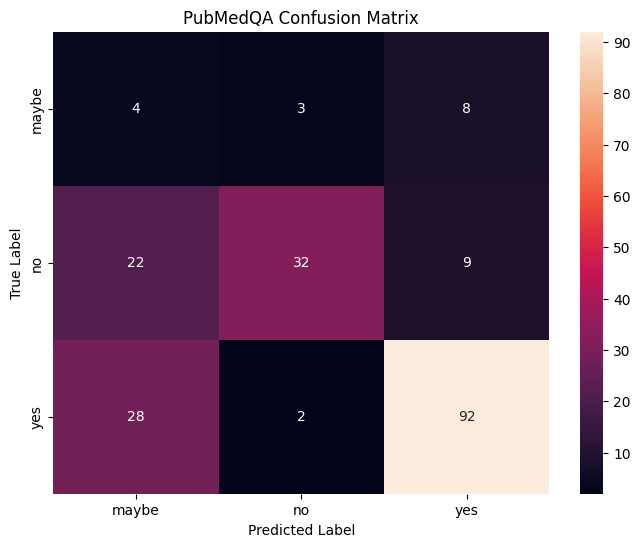


PubMedQA Results:
Accuracy: 0.6400
Precision: 0.7929
Recall: 0.6400
F1 Score: 0.6962

Evaluating MedQA...
Evaluating on 100 test samples.


Evaluating MedQA:   0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'extract_first_digit' is not defined

In [ ]:
print("\nRunning evaluations with Unsloth model...")

print("\nEvaluating PubMedQA...")
pubmed_inputs, pubmed_preds, pubmed_trues = evaluate_pubmedqa(train_data, test_data)




Evaluating MedQA...
Evaluating on 100 test samples.


Evaluating MedQA: 100%|██████████| 100/100 [00:51<00:00,  1.94it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MedQA Evaluation Results:
Number of Test Samples: 100


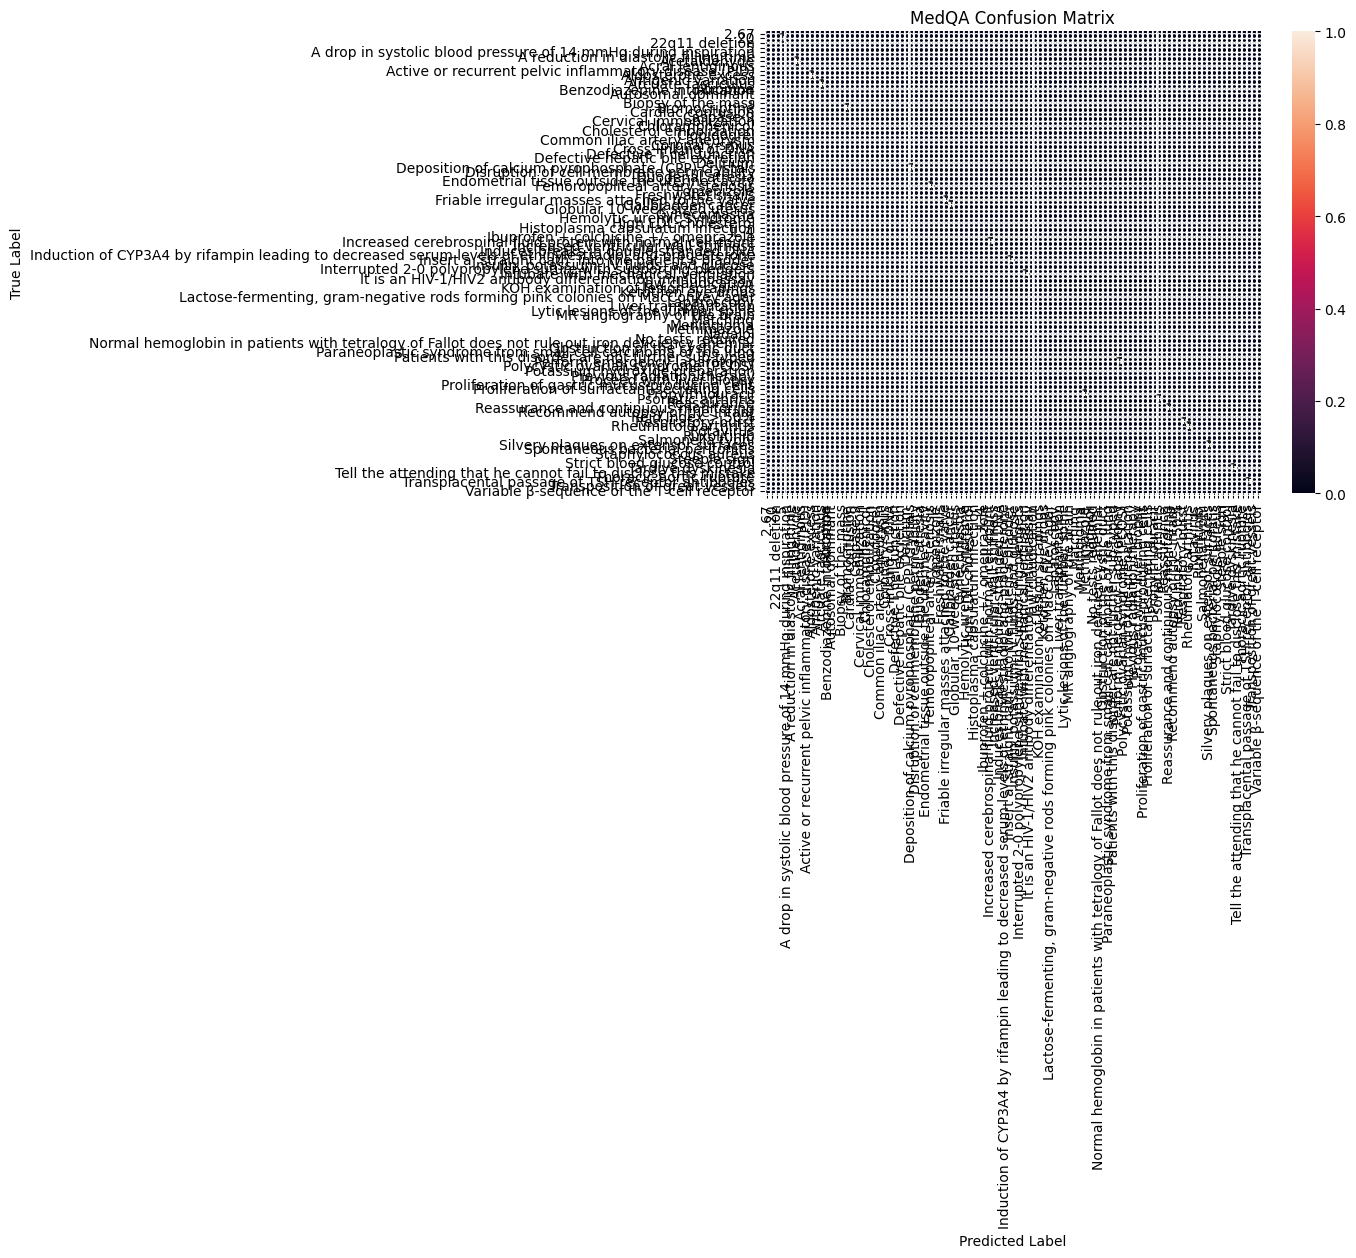


MedQA Results:
Accuracy: 0.1900
Precision: 0.1900
Recall: 0.1900
F1 Score: 0.1900

Evaluating MedMCQA...


README.md:   0%|          | 0.00/10.7k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/85.9M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/936k [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.48M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/182822 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/6150 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/4183 [00:00<?, ? examples/s]

Evaluating MedMCQA: 100%|██████████| 100/100 [00:33<00:00,  2.95it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MedMCQA Validation Results (100 samples):


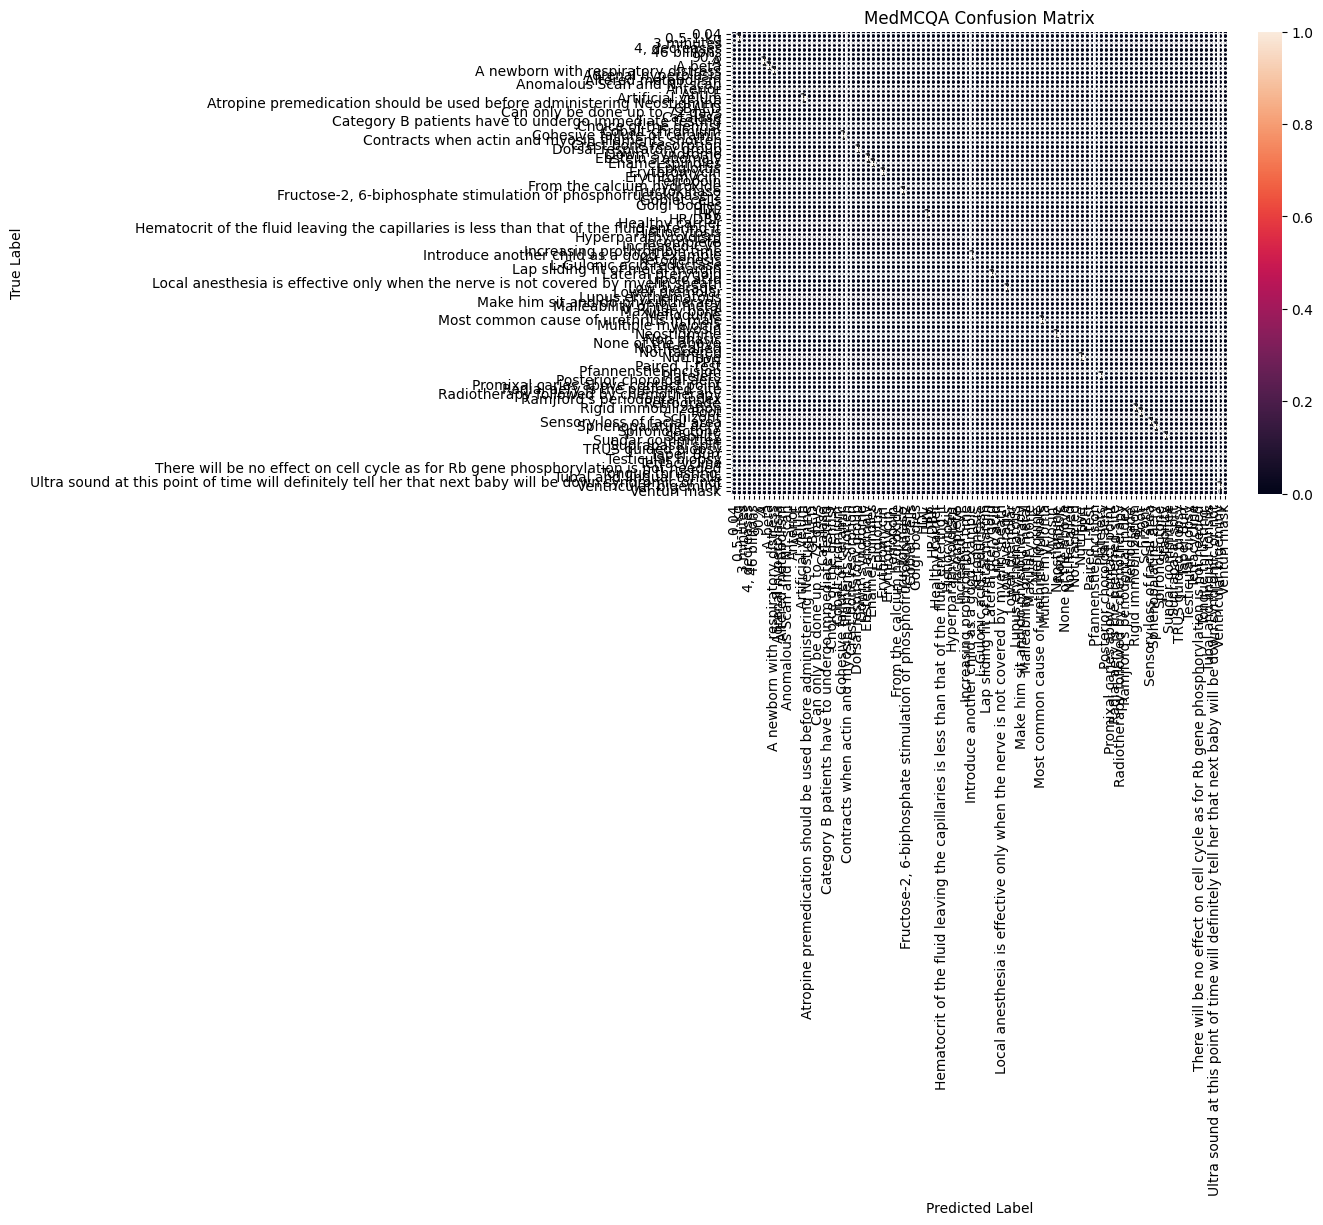


MedMCQA Results:
Accuracy: 0.2500
Precision: 0.2500
Recall: 0.2500
F1 Score: 0.2500

Showing some random samples from MedQA predictions:

Question: A 62-year-old patient has been hospitalized for a week due to a stroke. One week into the hospitalization, he develops a fever and purulent cough. His vitals include: heart rate 88/min, respiratory rate 20/min, temperature 38.4°C (101.1°F), and blood pressure 110/85 mm Hg. On physical examination, he has basal crackles on the right side of the chest. Chest radiography shows a new consolidation on the same side. Complete blood count is as follows:
Hemoglobin 16 mg/dL
Hematocrit 50%
Leukocyte count 8,900/mm3
Neutrophils 72%
Bands 4%
Eosinophils 2%
Basophils 0%
Lymphocytes 17%
Monocytes 5%
Platelet count 280,000/mm3
What is the most likely causal microorganism?
Options: ['Pseudomona aeruginosa', 'Streptococcus pneumoniae', 'Mycobacterium tuberculosis', 'Haemophilus influenzae', 'Staphylococcus aureus']
Model Prediction: Haemophilus influenzae

In [ ]:
print("\nEvaluating MedQA...")
medqa_inputs, medqa_preds, medqa_trues = evaluate_medqa(num_tests=100)

print("\nEvaluating MedMCQA...")
medmcqa_inputs, medmcqa_preds, medmcqa_trues = evaluate_medmcqa(100)

# Analyze some random samples from MedQA where the model got it wrong
all_indices = list(range(len(medqa_inputs)))
random.shuffle(all_indices)

print("\nShowing some random samples from MedQA predictions:")
for i in all_indices[:5]:  # show 5 random samples
    q, opts = medqa_inputs[i]
    pred = medqa_preds[i]
    true_ans = medqa_trues[i]

    print(f"\nQuestion: {q}")
    print(f"Options: {opts}")
    print(f"Model Prediction: {pred}")
    print(f"True Answer: {true_ans}")



In [ ]:

def analyze_explanations(inputs_list, preds, trues, dataset_name, num_samples_correct=3, num_samples_incorrect=3):
    # Identify correct and incorrect indices
    correct_indices = [i for i, (p, t) in enumerate(zip(preds, trues)) if p == t]
    incorrect_indices = [i for i, (p, t) in enumerate(zip(preds, trues)) if p != t]

    random.shuffle(correct_indices)
    random.shuffle(incorrect_indices)

    # Sample a few from each
    samples_correct = correct_indices[:num_samples_correct]
    samples_incorrect = incorrect_indices[:num_samples_incorrect]

    print(f"\n=== {dataset_name}: Analysis of Correctly Answered Questions ===\n")
    for i in samples_correct:
        input_data = inputs_list[i]
        pred = preds[i]
        true_ans = trues[i]

        if dataset_name == "PubMedQA":
            # input_data is (context, question)
            context, question = input_data
            # For explanation, we can consider the answer is "yes/no/maybe"
            # We'll just treat these as options for demonstration, or a single answer scenario
            # If you want more complex reasoning, adapt prompt accordingly.
            options = [true_ans]  # No multiple choice here, just a direct answer
            print(f"Question: {question}")
            print(f"True Answer: {true_ans}")
            print(f"Model Prediction: {pred}")
            explanation = explain_model_reasoning(model, tokenizer, question, options, pred)
            print("Explanation:", explanation)
            print("-" * 80)
        else:
            # input_data is (question, options) for MedQA and MedMCQA
            question, options = input_data
            print(f"Question: {question}")
            print(f"Options: {options}")
            print(f"True Answer: {true_ans}")
            print(f"Model Prediction: {pred}")
            explanation = explain_model_reasoning(model, tokenizer, question, options, pred)
            print("Explanation:", explanation)
            print("-" * 80)

    print(f"\n=== {dataset_name}: Analysis of Incorrectly Answered Questions ===\n")
    for i in samples_incorrect:
        input_data = inputs_list[i]
        pred = preds[i]
        true_ans = trues[i]

        if dataset_name == "PubMedQA":
            context, question = input_data
            options = [true_ans]
            print(f"Question: {question}")
            print(f"True Answer: {true_ans}")
            print(f"Model Prediction: {pred}")
            explanation = explain_model_reasoning(model, tokenizer, question, options, pred)
            print("Explanation:", explanation)
            print("-" * 80)
        else:
            question, options = input_data
            print(f"Question: {question}")
            print(f"Options: {options}")
            print(f"True Answer: {true_ans}")
            print(f"Model Prediction: {pred}")
            explanation = explain_model_reasoning(model, tokenizer, question, options, pred)
            print("Explanation:", explanation)
            print("-" * 80)


# Analyze a few samples from each dataset
analyze_explanations(pubmed_inputs, pubmed_preds, pubmed_trues, "PubMedQA")
analyze_explanations(medqa_inputs, medqa_preds, medqa_trues, "MedQA")
analyze_explanations(medmcqa_inputs, medmcqa_preds, medmcqa_trues, "MedMCQA")



=== PubMedQA: Analysis of Correctly Answered Questions ===

Question: Is routine intraoperative frozen-section examination of sentinel lymph nodes in breast cancer worthwhile?
True Answer: maybe
Model Prediction: maybe


NameError: name 'explain_model_reasoning' is not defined

# Mistral-7B-v0.1 4Bit

In [ ]:
from unsloth import FastLanguageModel
from unsloth import is_bfloat16_supported
import torch

print("\nUnsloth imported successfully!")

# Load the base Mistral model
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name="mistralai/Mistral-7B-v0.1",
    max_seq_length=2048,
    dtype=None,
    load_in_4bit=True,
)

print("\nBase model loaded successfully!")

# Convert model for inference
model = FastLanguageModel.for_inference(model)
model.eval()




Unsloth imported successfully!
==((====))==  Unsloth 2024.12.4: Fast Mistral patching. Transformers:4.46.3.
   \\   /|    GPU: Tesla T4. Max memory: 14.748 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.5.1+cu121. CUDA: 7.5. CUDA Toolkit: 12.1. Triton: 3.1.0
\        /    Bfloat16 = FALSE. FA [Xformers = 0.0.28.post3. FA2 = False]
 "-____-"     Free Apache license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!

Base model loaded successfully!


MistralForCausalLM(
  (model): MistralModel(
    (embed_tokens): Embedding(32000, 4096, padding_idx=0)
    (layers): ModuleList(
      (0-31): 32 x MistralDecoderLayer(
        (self_attn): MistralAttention(
          (q_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (k_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (v_proj): Linear4bit(in_features=4096, out_features=1024, bias=False)
          (o_proj): Linear4bit(in_features=4096, out_features=4096, bias=False)
          (rotary_emb): LlamaRotaryEmbedding()
        )
        (mlp): MistralMLP(
          (gate_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (up_proj): Linear4bit(in_features=4096, out_features=14336, bias=False)
          (down_proj): Linear4bit(in_features=14336, out_features=4096, bias=False)
          (act_fn): SiLU()
        )
        (input_layernorm): MistralRMSNorm((4096,), eps=1e-05)
        (post_attention_layernorm): Mis


Running evaluations with Unsloth model...

Evaluating PubMedQA...


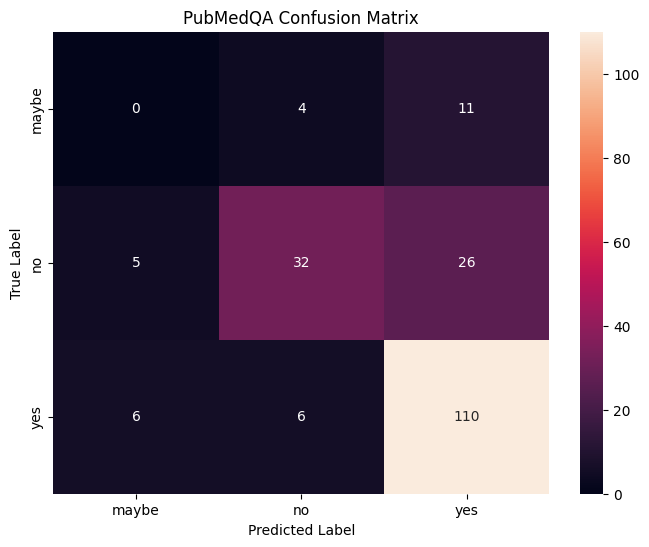


PubMedQA Results:
Accuracy: 0.7100
Precision: 0.6965
Recall: 0.7100
F1 Score: 0.6909

Evaluating MedQA...
Evaluating on 100 test samples.


Evaluating MedQA: 100%|██████████| 100/100 [01:18<00:00,  1.28it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MedQA Evaluation Results:
Number of Test Samples: 100


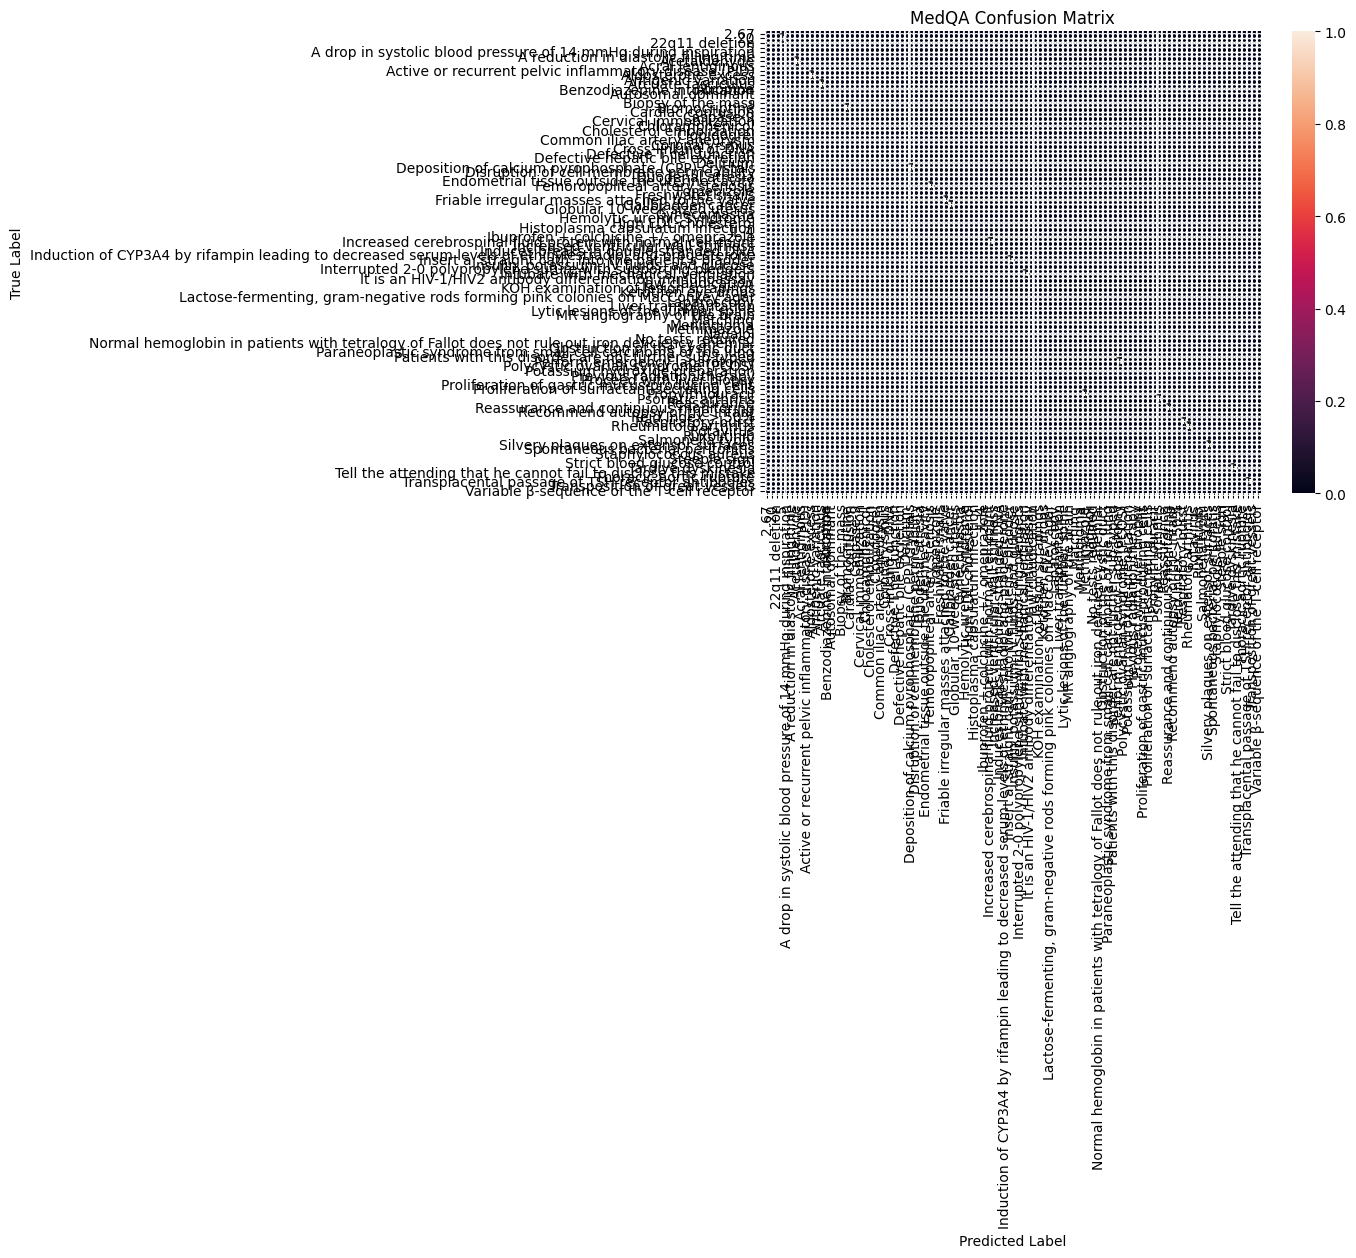


MedQA Results:
Accuracy: 0.1900
Precision: 0.1900
Recall: 0.1900
F1 Score: 0.1900

Evaluating MedMCQA...


Evaluating MedMCQA: 100%|██████████| 100/100 [01:05<00:00,  1.52it/s]
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



MedMCQA Validation Results (100 samples):


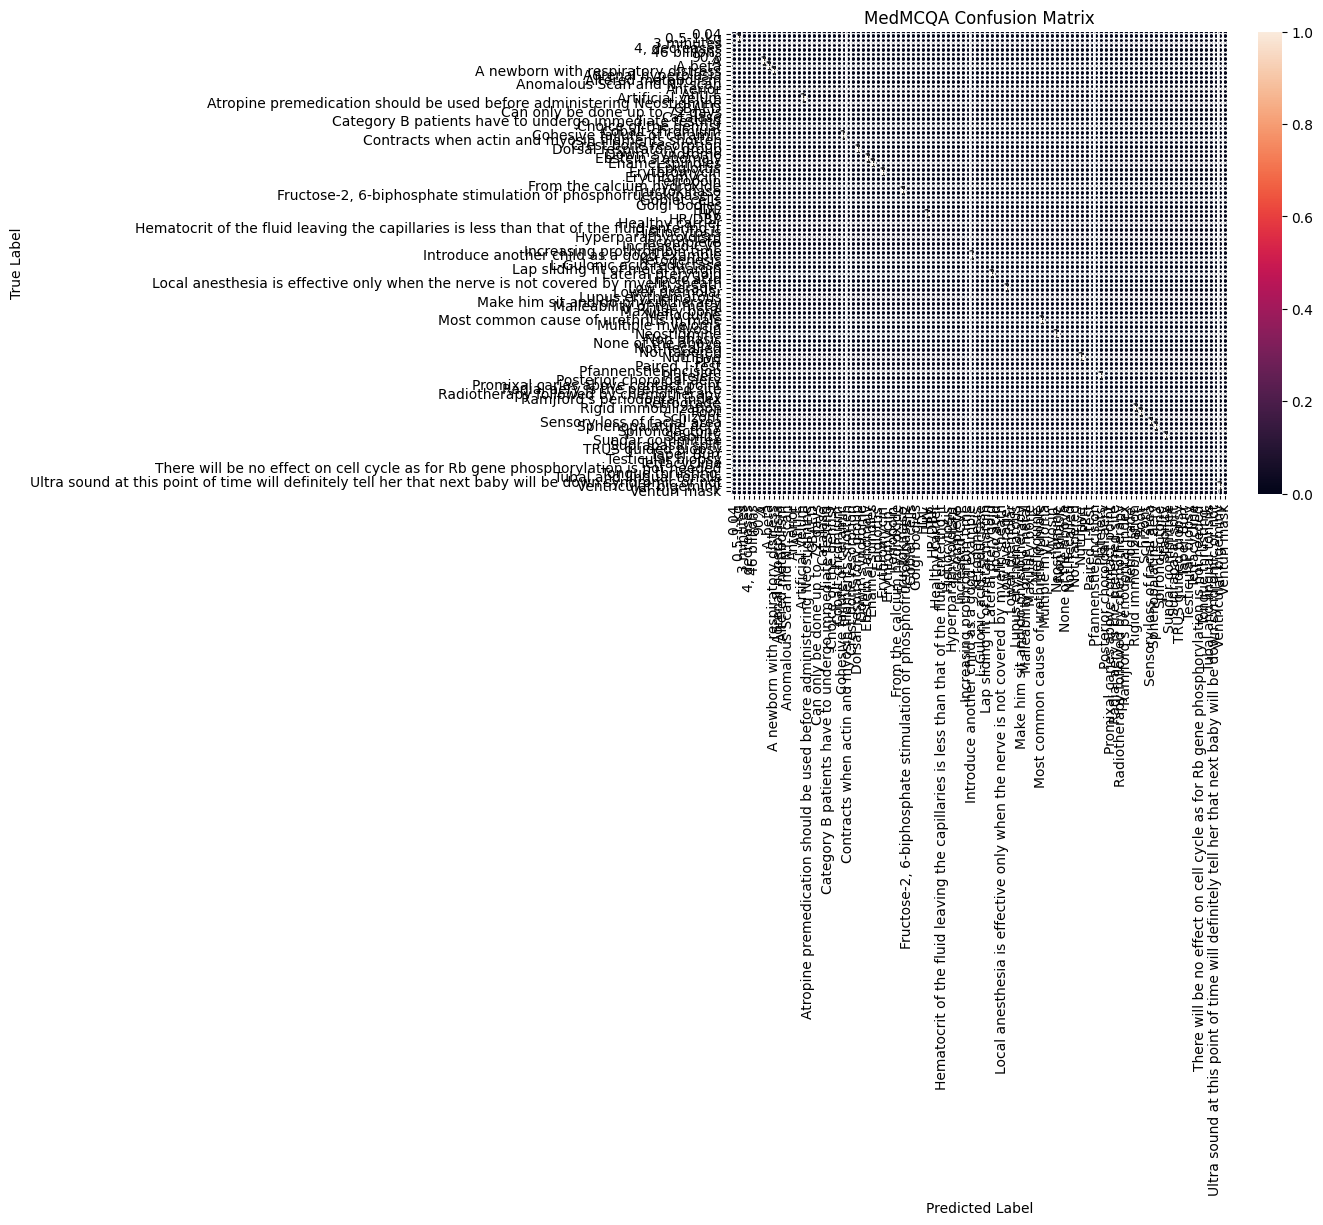


MedMCQA Results:
Accuracy: 0.2500
Precision: 0.2500
Recall: 0.2500
F1 Score: 0.2500

Showing some random samples from MedQA predictions:

Question: A 67-year-old man is hospitalized after several days of fever and increasing shortness of breath. Respiratory viral panel returns positive for influenza A and the patient is started on a standard five day course of oseltamivir. Despite therapy, his shortness of breath continues to worsen and his oxygen saturation decreases to the point where ICU transfer and intubation are required. Chest radiograph shows bilateral infiltrates. Clinical criteria are consistent with development of Acute Respiratory Distress Syndrome (ARDS). After several weeks of supportive therapy, the patient improves with lung function returning to near normal. Which of the following processes is involved in the regeneration of alveolar lining after damage to alveoli occurs?
Options: ['Squamous cell proliferation', 'Sweeping of debris out of the alveoli by ciliated cells

In [ ]:
print("\nRunning evaluations with Unsloth model...")

print("\nEvaluating PubMedQA...")
pubmed_inputs, pubmed_preds, pubmed_trues = evaluate_pubmedqa(train_data, test_data)

print("\nEvaluating MedQA...")
medqa_inputs, medqa_preds, medqa_trues = evaluate_medqa(num_tests=100)

print("\nEvaluating MedMCQA...")
medmcqa_inputs, medmcqa_preds, medmcqa_trues = evaluate_medmcqa(100)

# Analyze some random samples from MedQA where the model got it wrong
all_indices = list(range(len(medqa_inputs)))
random.shuffle(all_indices)

print("\nShowing some random samples from MedQA predictions:")
for i in all_indices[:5]:  # show 5 random samples
    q, opts = medqa_inputs[i]
    pred = medqa_preds[i]
    true_ans = medqa_trues[i]

    print(f"\nQuestion: {q}")
    print(f"Options: {opts}")
    print(f"Model Prediction: {pred}")
    print(f"True Answer: {true_ans}")

    # You can add logic to see if explanation is good or not.
    # For example, you can also prompt the model to explain its reasoning:
    # This would require generating another prompt like:
    # explain_prompt = f"Question: {q}\nOptions: {opts}\nThe model chose: {pred}\nExplain the reasoning:"
    # Then generate output from the model and see if explanation matches reasoning.


In [ ]:
# After running evaluations, we have medqa_inputs, medqa_preds, medqa_trues from the previous code.

# Let's analyze some samples and generate explanations.

import random

def explain_model_reasoning(model, tokenizer, question, options, chosen_answer, max_seq_length=2048):
    """
    Ask the model to explain its reasoning for the chosen answer.
    """
    explain_prompt = (
        f"Question: {question}\n"
        f"Options:\n"
    )
    for i, opt in enumerate(options, 1):
        explain_prompt += f"{i}. {opt}\n"
    explain_prompt += (
        f"\nThe model chose: {chosen_answer}\n"
        f"Explain the reasoning for why this might be the correct answer."
    )

    inputs = tokenizer(
        explain_prompt, return_tensors="pt", max_length=max_seq_length, truncation=True
    ).to(model.device)

    with torch.no_grad():
        explanation_outputs = model.generate(
            **inputs,
            max_new_tokens=128,
            temperature=1.0,
            do_sample=True
        )
    explanation = tokenizer.decode(explanation_outputs[0], skip_special_tokens=True)
    return explanation


In [ ]:

def analyze_explanations(inputs_list, preds, trues, dataset_name, num_samples_correct=3, num_samples_incorrect=3):
    # Identify correct and incorrect indices
    correct_indices = [i for i, (p, t) in enumerate(zip(preds, trues)) if p == t]
    incorrect_indices = [i for i, (p, t) in enumerate(zip(preds, trues)) if p != t]

    random.shuffle(correct_indices)
    random.shuffle(incorrect_indices)

    # Sample a few from each
    samples_correct = correct_indices[:num_samples_correct]
    samples_incorrect = incorrect_indices[:num_samples_incorrect]

    print(f"\n=== {dataset_name}: Analysis of Correctly Answered Questions ===\n")
    for i in samples_correct:
        input_data = inputs_list[i]
        pred = preds[i]
        true_ans = trues[i]

        if dataset_name == "PubMedQA":
            # input_data is (context, question)
            context, question = input_data
            # For explanation, we can consider the answer is "yes/no/maybe"
            # We'll just treat these as options for demonstration, or a single answer scenario
            # If you want more complex reasoning, adapt prompt accordingly.
            options = [true_ans]  # No multiple choice here, just a direct answer
            print(f"Question: {question}")
            print(f"True Answer: {true_ans}")
            print(f"Model Prediction: {pred}")
            explanation = explain_model_reasoning(model, tokenizer, question, options, pred)
            print("Explanation:", explanation)
            print("-" * 80)
        else:
            # input_data is (question, options) for MedQA and MedMCQA
            question, options = input_data
            print(f"Question: {question}")
            print(f"Options: {options}")
            print(f"True Answer: {true_ans}")
            print(f"Model Prediction: {pred}")
            explanation = explain_model_reasoning(model, tokenizer, question, options, pred)
            print("Explanation:", explanation)
            print("-" * 80)

    print(f"\n=== {dataset_name}: Analysis of Incorrectly Answered Questions ===\n")
    for i in samples_incorrect:
        input_data = inputs_list[i]
        pred = preds[i]
        true_ans = trues[i]

        if dataset_name == "PubMedQA":
            context, question = input_data
            options = [true_ans]
            print(f"Question: {question}")
            print(f"True Answer: {true_ans}")
            print(f"Model Prediction: {pred}")
            explanation = explain_model_reasoning(model, tokenizer, question, options, pred)
            print("Explanation:", explanation)
            print("-" * 80)
        else:
            question, options = input_data
            print(f"Question: {question}")
            print(f"Options: {options}")
            print(f"True Answer: {true_ans}")
            print(f"Model Prediction: {pred}")
            explanation = explain_model_reasoning(model, tokenizer, question, options, pred)
            print("Explanation:", explanation)
            print("-" * 80)


# Analyze a few samples from each dataset
analyze_explanations(pubmed_inputs, pubmed_preds, pubmed_trues, "PubMedQA")
analyze_explanations(medqa_inputs, medqa_preds, medqa_trues, "MedQA")
analyze_explanations(medmcqa_inputs, medmcqa_preds, medmcqa_trues, "MedMCQA")



=== PubMedQA: Analysis of Correctly Answered Questions ===

Question: Can bisphosphonate treatment be stopped in a growing child with skeletal fragility?
True Answer: maybe
Model Prediction: maybe
Explanation: Question: Can bisphosphonate treatment be stopped in a growing child with skeletal fragility?
Options:
1. maybe

The model chose: maybe
Explain the reasoning for why this might be the correct answer.

The question asks about bisphosphonate treatment in a growing child with skeletal fragility. Bisphosphonates are a class of drugs used to treat conditions such as osteoporosis and Paget's disease by slowing down the rate of bone turnover. However, they can have detrimental effects on the growing bones of children, leading to reduced bone growth, bone pain, and an increased risk of fractures.

Therefore, the decision to stop bisphosphonate treatment in a growing child with skeletal fragility depends on the specific case and the benefit
-----------------------------------------------

# Model Size Calculation

In [ ]:
print(type(model))
print(model)

# Get total params
total_params = sum(p.numel() for p in model.parameters())
precision_bits = 4  # 4-bit quantization
model_size_mb = (total_params * precision_bits) / (8 * 1024 * 1024)
print(f"Estimated model size: {model_size_mb:.2f} MB")


Load Llama-2-7B and Calculate Size


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM
import torch

model_name = "meta-llama/Llama-2-7b-hf"
tokenizer = AutoTokenizer.from_pretrained(model_name, use_auth_token=True)
model = AutoModelForCausalLM.from_pretrained(model_name, use_auth_token=True)
tokenizer.pad_token = tokenizer.eos_token
model.config.pad_token_id = tokenizer.eos_token_id

if torch.cuda.device_count() > 1:
    model = torch.nn.DataParallel(model)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

total_params = sum(p.numel() for p in model.parameters())
precision_bits = 32
model_size_mb = (total_params * precision_bits) / (8 * 1024 * 1024)
model_size_mb
